In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import metrics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import Counter
import tensorflow as tf
import scipy.stats
import pandas as pd
from tensorflow.contrib.metrics import streaming_pearson_correlation
from keras.models import load_model
from functools import partial
from sklearn.preprocessing import maxabs_scale, minmax_scale, normalize, scale, robust_scale

/home/nlarusstone/.virtualenvs/nls/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import cobra
%load_ext autoreload
import sys
if not '/home/nlarusstone/cf_fba' in sys.path:
    sys.path.append('/home/nlarusstone/cf_fba')
import src.utils as utils
import src.flux_utils as futils
%autoreload 2

In [3]:
df = pd.read_csv('../data/Karim_MetEng_2018_Figure2_Data.csv')
df.drop(columns=['Area_1', 'Area_2', 'Conc_1', 'Conc_2'], inplace=True)
n_experiments = df.shape[0]
df.head()

,AVG,STD,AVG.1,STD.1,Mg(Glu)2,NH4(Glu),K(Glu),Glucose,K2HPO4,NAD,ATP,CoA
0,0.00,0.0,0.00,0.00,8.0,10.0,134,0,10,0.5,0.0,0.5
1,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.0,0.0,0.5
2,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.5,0.0,2.0
3,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.5,0.0,1.6
4,1.21,1.7,0.09,0.13,8.0,10.0,134,200,10,0.5,2.0,0.5


In [4]:
y_vals = futils.scale_data(data=df['AVG.1'].values, scale_type='flux_zero', in_place=False)

1


In [6]:
X_train, y_train, X_test, y_test, btol_col, cols = futils.read_data('../data/flux_samps_2k', 
                                                                    n_rows=50000, scale='flux_zero')

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
done
Min: 0.0, Max: 1.0


In [85]:
#np.savez_compressed('../data/fluxes_resampled', train=X_train, test=X_test)
#dat = np.load('../data/fluxes_resampled.npz')

In [7]:
latent_dim = 2
epsilon_std = 1.0

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], n_experiments, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

def corr_loss_np(y_true, y_pred):
    cent_pred = y_pred - np.mean(y_pred)
    cent_tr = y_true - np.mean(y_true)

    std_pred = np.std(y_pred)
    std_tr = np.std(y_true)

    return np.mean(cent_pred*cent_tr)/(std_pred*std_tr)

def corr_loss(y_true, y_pred):
    cent_pred = y_pred - K.mean(y_pred)
    cent_tr = y_true - K.mean(y_true)

    std_pred = K.std(y_pred)
    std_tr = K.std(y_true)
    return K.mean(cent_pred*cent_tr)/(std_pred*std_tr)

# y_true, y_pred
def gen_vae_loss(y_true, x_decoded_mean, z_log_var, z_mean):
    output_flux = x_decoded_mean[:, :, output_ind]
    #experiment_loss = scipy.stats.spearmanr(targets, output_flux)
    #experiment_loss = pearson_corr(output_flux, targets)#streaming_pearson_correlation(output_flux, targets)
    xent_loss = X_shape * metrics.mean_squared_error(y_true, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)# + experiment_loss
    return vae_loss

def kl_loss(z_log_var, z_mean):
    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

def build_vae(X_shape, n_experiments, targets, output_ind, corr_impt, batch_size=100):
    encoded_dim1 = 1024
    encoded_sz = 256
    # Encoder network
    x = Input(shape=(n_experiments, X_shape,))
    #h = Dense(encoded_dim1, activation='relu')(x)
    h = Dense(encoded_sz, activation='relu')(x)#h)
    z_mean = Dense(latent_dim, name='z_mean')(h)
    z_log_var = Dense(latent_dim, name='z_log_var')(h)
    
    # Sample points from latent space
    z = Lambda(sampling, output_shape=(n_experiments,latent_dim,))([z_mean, z_log_var])
    
    # Decoder network
    decoder_h = Dense(encoded_sz, activation='relu')
    #decoder_h2 = Dense(encoded_dim1, activation='relu')
    decoder_mean = Dense(X_shape, activation='tanh')
    h_decoded = decoder_h(z)
    #h_decoded2 = decoder_h2(h_decoded)
    x_decoded_mean = decoder_mean(h_decoded)#2)

    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)
    #vae = Model(x, [x_decoded_mean, x_decoded_mean])
    output_flux = x_decoded_mean[:, :, output_ind]
    #experiment_loss = scipy.stats.spearmanr(targets, output_flux)
    experiment_loss_val = -1 * corr_loss(targets, output_flux)#streaming_pearson_correlation(output_flux, targets)
    xent_loss = x.shape[-1].value * metrics.mean_squared_error(x, x_decoded_mean)
    kl_loss_val = kl_loss(z_log_var, z_mean)
    vae_loss = K.mean(xent_loss + kl_loss_val) + corr_impt * experiment_loss_val
    #print x.shape, x_decoded_mean.shape, z_mean.shape, z_log_var.shape
    #print xent_loss.shape, kl_loss_val.shape, experiment_loss_val.shape, vae_loss.shape
    #vae_loss = K.sum(vae_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    #vae.compile(optimizer='rmsprop', loss=[lambda x, x_pred: gen_vae_loss(x, x_pred, z_log_var, z_mean),
    #                                       lambda x, x_pred: corr_loss(targets, x_pred[:, :, output_ind])])
    vae.summary()

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(n_experiments, latent_dim,))
    _h_decoded = decoder_h(decoder_input)
    #_h_decoded2 = decoder_h2(_h_decoded)
    _x_decoded_mean = decoder_mean(_h_decoded)#2)
    generator = Model(decoder_input, _x_decoded_mean)
    return vae, encoder, generator

In [9]:
from keras.callbacks import Callback
from sklearn.metrics import mean_squared_error as mse
class LossHistory(Callback):
    def __init__(self):
        self.recon_losses = []
        self.kl_losses = []
        self.corr_losses = []
        
    def on_epoch_end(self, epoch, logs={}):
        y_true = self.validation_data[0]
        y_pred = self.model.predict(self.validation_data[0])
        corr_loss = -1 * corr_loss_np(df['AVG.1'].values, y_pred[:, :, output_ind])
        xent_loss = y_true.shape[-1] * np.mean(np.square(y_true - y_pred), axis=-1)
        inputs = [K.learning_phase()] + self.model.inputs
        zvar = K.function(inputs=inputs, outputs=[self.model.get_layer('z_log_var').output])
        zmn = K.function(inputs=inputs, outputs=[self.model.get_layer('z_mean').output])
        z_log_var = zvar([0, self.validation_data[0]])[0]
        z_mean = zmn([0, self.validation_data[0]])[0]
        kl_loss = - 0.5 * np.sum(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var), axis=-1)
        print "Reconstruction loss: {0}".format(np.mean(xent_loss))
        print "KL loss: {0}".format(np.mean(kl_loss))
        print "Corr loss: {0}".format(corr_loss)
        self.recon_losses.append(np.mean(xent_loss))
        self.kl_losses.append(np.mean(kl_loss))
        self.corr_losses.append(corr_loss)

In [ ]:
#%%debug
batch_size = 256
X_shape, n_experiments = X_train.shape[2], df.shape[0]
targets = tf.convert_to_tensor(y_vals, dtype=tf.float32)
output_ind = btol_col
corr_impt = 2
vae, encoder, generator = build_vae(X_shape, n_experiments, targets, output_ind, corr_impt, batch_size)
es = EarlyStopping(patience=35
lh = LossHistory()
#with tf.Session(config=tf.ConfigProto(
#                    intra_op_parallelism_threads=32)) as sess:
#    K.set_session(sess)
hist = vae.fit(X_train,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(X_test, None),
        callbacks=[es, lh])
#encoder.save('encoder_{0}.h5'.format(scale))
#generator.save('generator{0}.h5'.format(scale))

/home/nlarusstone/.virtualenvs/nls/lib/python2.7/site-packages/ipykernel_launcher.py:74 UserWarning: Output "dense_6" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_6" during training.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 41, 2639)     0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 41, 256)      675840      input_3[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 41, 2)        514         dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 41, 2)        514         dense_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (

In [20]:
lh.corr_losses

[-0.23068489119965394,
 -0.3012235605618345,
 -0.4200926270062547,
 -0.5963769342157728,
 -0.5978421546231192,
 -0.6285417908608943,
 -0.6212982099753435,
 -0.6354867760795083,
 -0.6723391069494431,
 -0.6320018281728353,
 -0.6922309101586476,
 -0.6945959416175355,
 -0.7362681471937086,
 -0.7224682741489212,
 -0.7244024973838625,
 -0.7557441389330317,
 -0.7581454457895669,
 -0.7725200753207763,
 -0.766678103352411,
 -0.7369827472693606]

In [153]:
with open('hi2', 'r') as f:
    b = pickle.load(f)

In [157]:
X_train, y_train, X_test, y_test, btol_col, cols = futils.read_data('../data/flux_samps_2k', scale='flux_max_abs')

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
done


In [159]:
np.min(X_train)

-8998.066371577112

In [151]:
with open('hi2', 'w') as f:
    pickle.dump(file=f, obj={'recon_losses': lh.recon_losses, 'kl_losses': lh.kl_losses, 'corr_losses': lh.corr_losses})

In [80]:
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
x_test_gen = generator.predict(x_test_encoded, batch_size=batch_size)
#x_test_encoded

In [6]:
def check_corr(gen_fluxes, df, btol_col):
    corrs = []
    for i in range(gen_fluxes.shape[0]):
        corr = scipy.stats.pearsonr(gen_fluxes[i, :, btol_col], df['AVG.1'])
        corrs.append(corr)
    mn = np.mean(corrs, axis=0)
    print mn
    print corrs[:5]
    return mn[0]
check_corr(x_test_gen, df, btol_col)

NameError: name 'x_test_gen' is not defined

In [45]:
def get_rct(df, rct, y_test):
    y_new = []
    for ind in y_test:
        y_new.append(df[rct][ind])
    return y_new
#get_rct(df, 'Glucose', y_test)

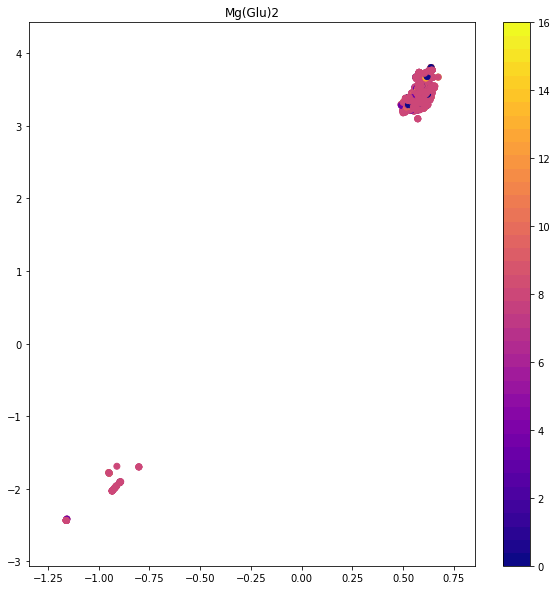

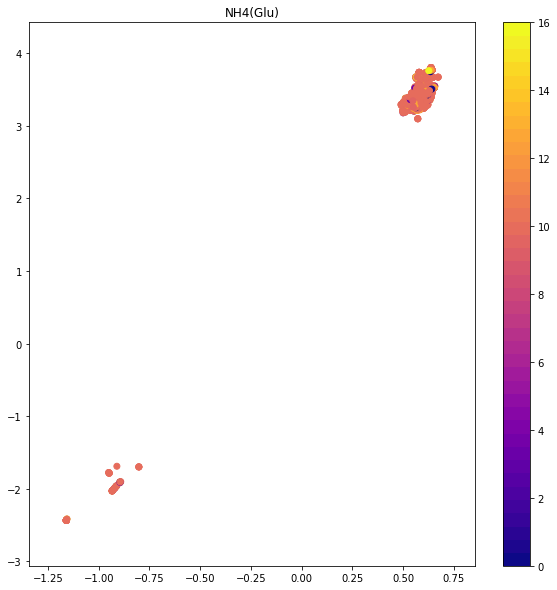

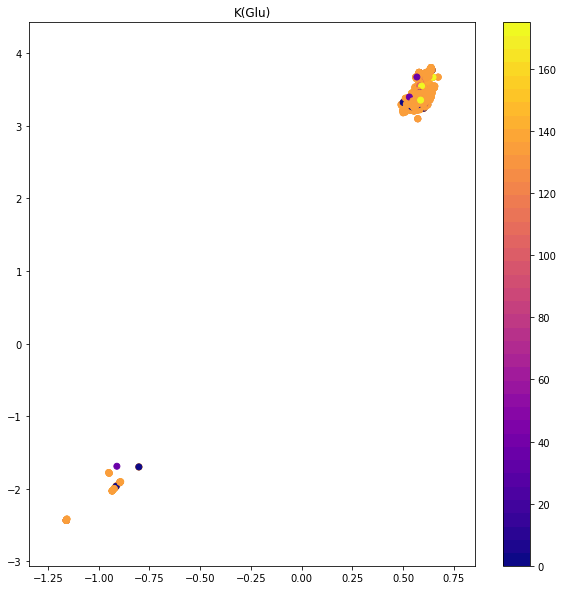

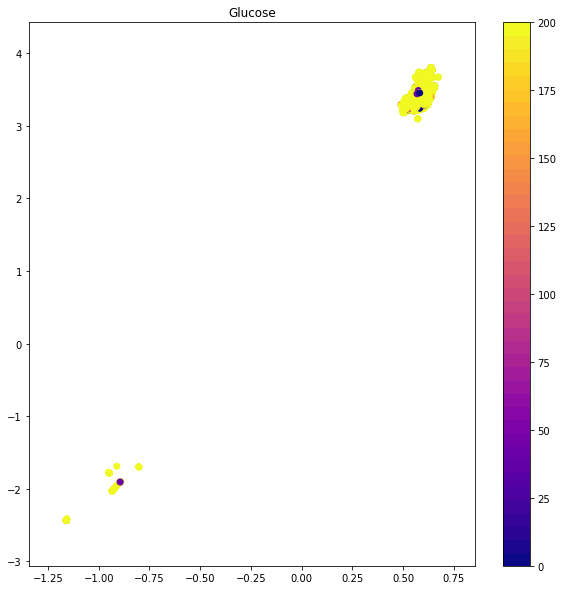

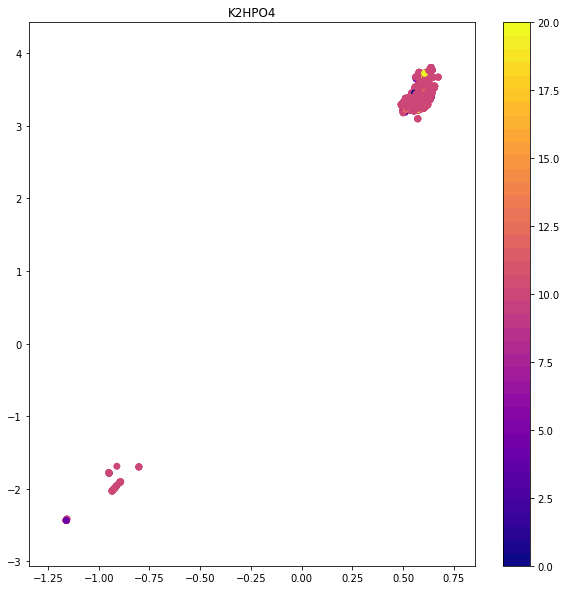

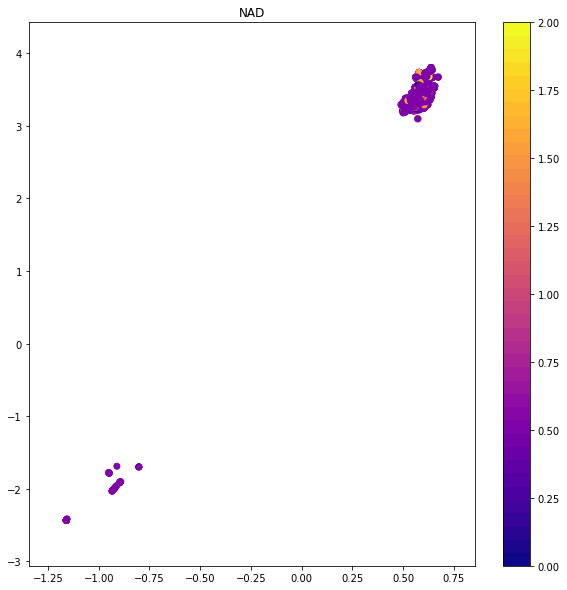

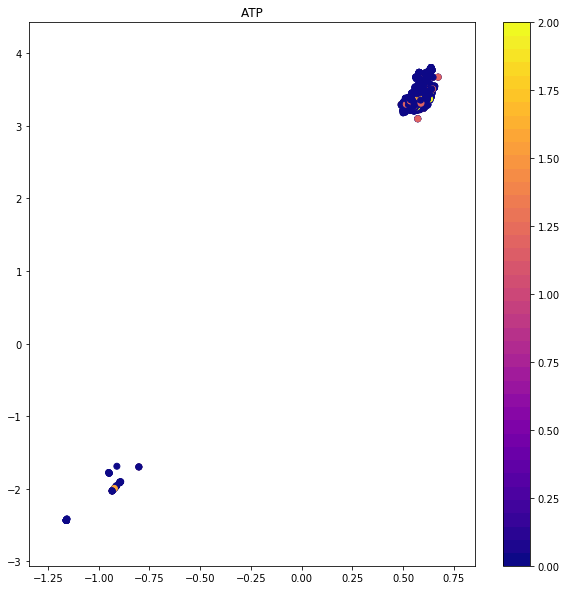

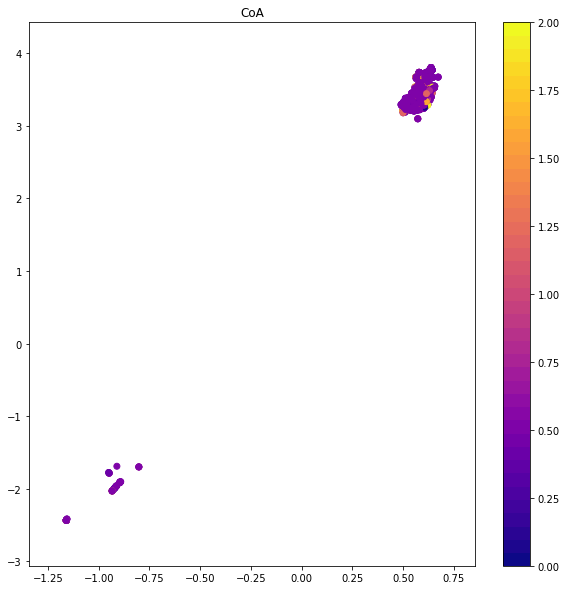

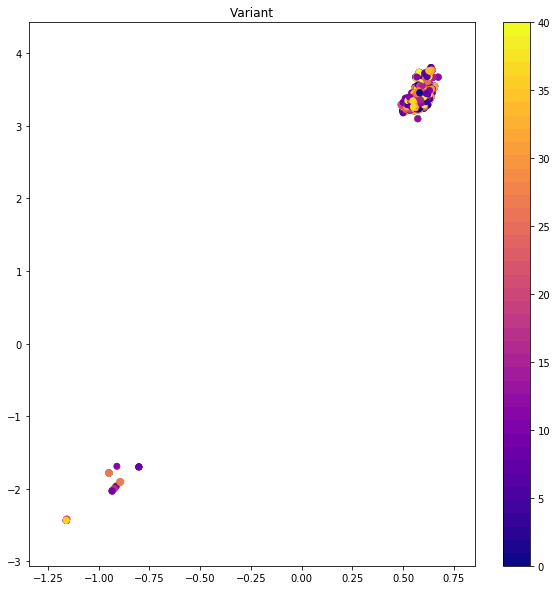

In [82]:
#cm1 = cm.get_cmap('tab20b', 20)
#cm2 = cm.get_cmap('tab20c', 20)
cmap = cm.get_cmap('plasma', 41)
#cmap = lambda x: cm1(x) if x < 21 else cm2(x)
#for j in range(41):
j = 0
xmin, xmax = np.amin(x_test_encoded[:, j, 0]), np.amax(x_test_encoded[:, j, 0])
ymin, ymax = np.amin(x_test_encoded[:, j, 1]), np.amax(x_test_encoded[:, j, 1])
x_diff = (xmax - xmin) / 10.0
y_diff = (ymax - ymin) / 10.0
for col in df.columns[4:]:
    plt.figure(figsize=(10, 10))
    plt.scatter(x_test_encoded[:, j, 0], x_test_encoded[:, j, 1], c=get_rct(df, col, y_test), cmap=cmap)
    plt.xlim((xmin - x_diff, xmax + x_diff))
    plt.ylim((ymin - y_diff, ymax + y_diff))
    plt.title(col)
    plt.colorbar()
    plt.show()

plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, j, 0], x_test_encoded[:, j, 1], c=y_test, cmap=cmap)
plt.xlim((xmin - x_diff, xmax + x_diff))
plt.ylim((ymin - y_diff, ymax + y_diff))
plt.title('Variant')
plt.colorbar()
plt.show()

In [47]:
x_test_encoded.shape

(2000, 41, 2)

In [52]:
x_test_dim_1, x_test_dim_2 = np.mean(x_test_encoded, axis=1)[:, :]

ValueError: too many values to unpack

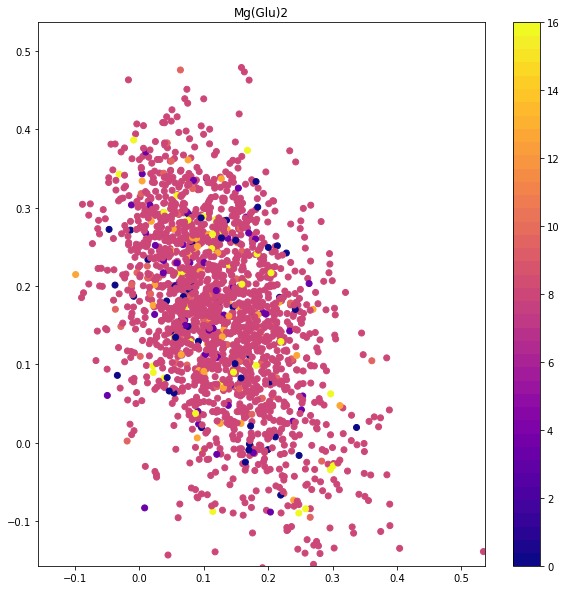

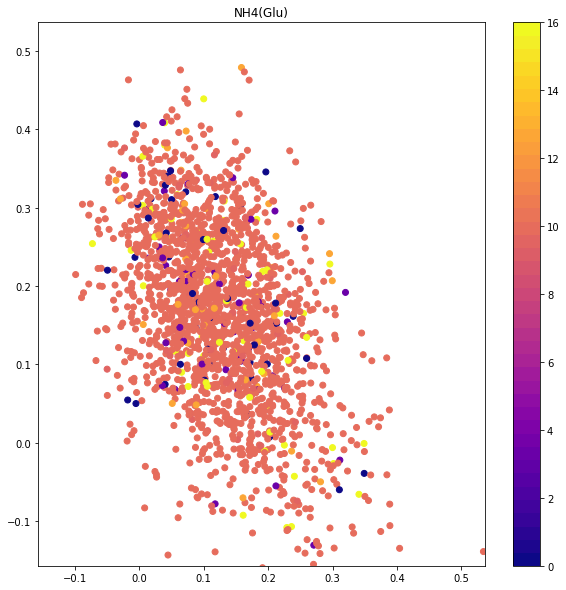

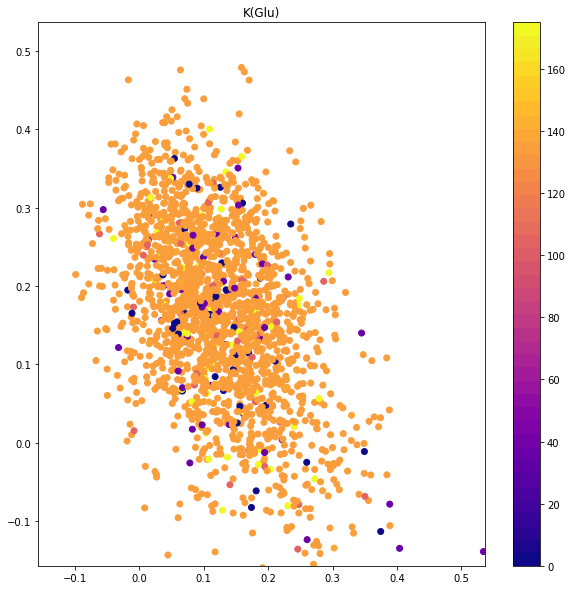

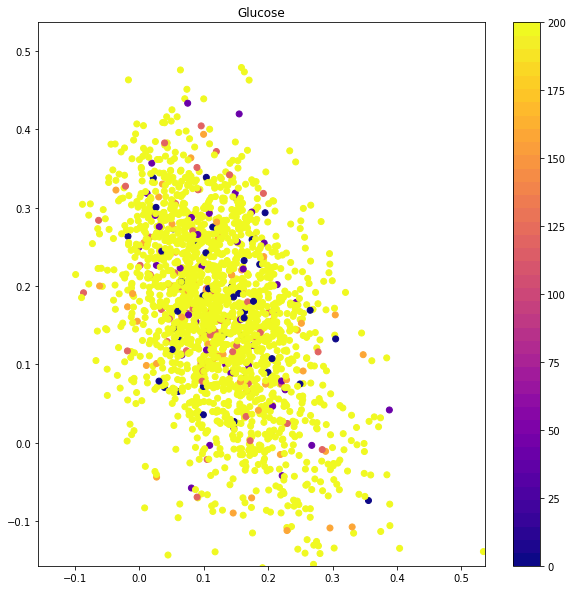

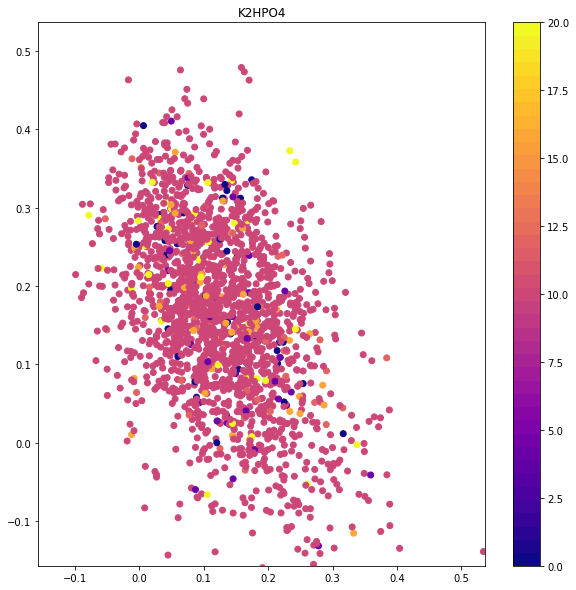

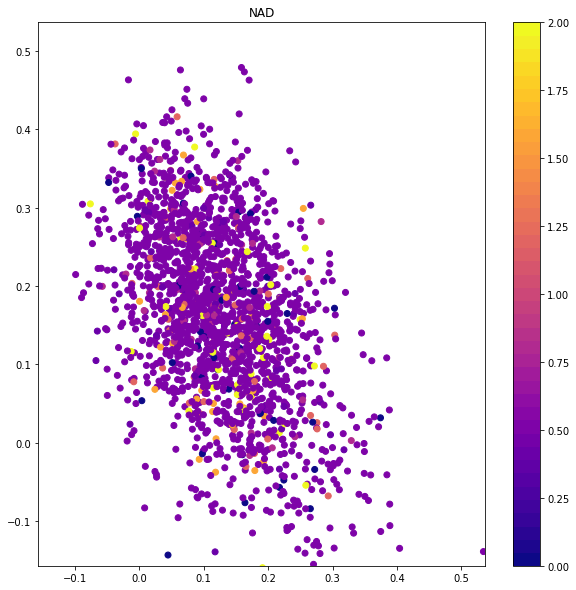

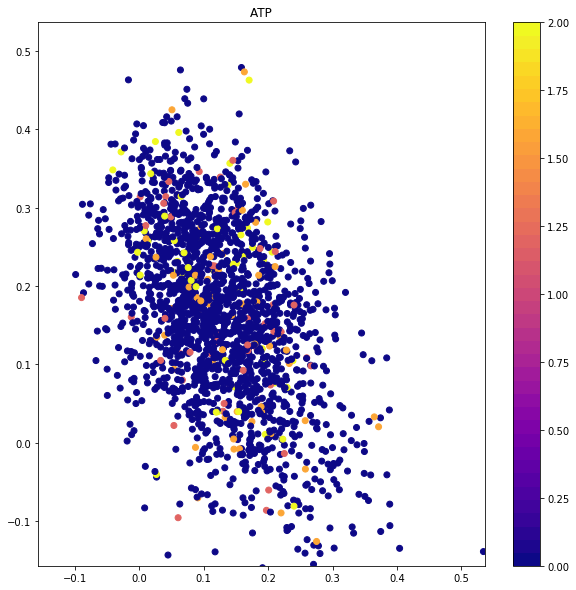

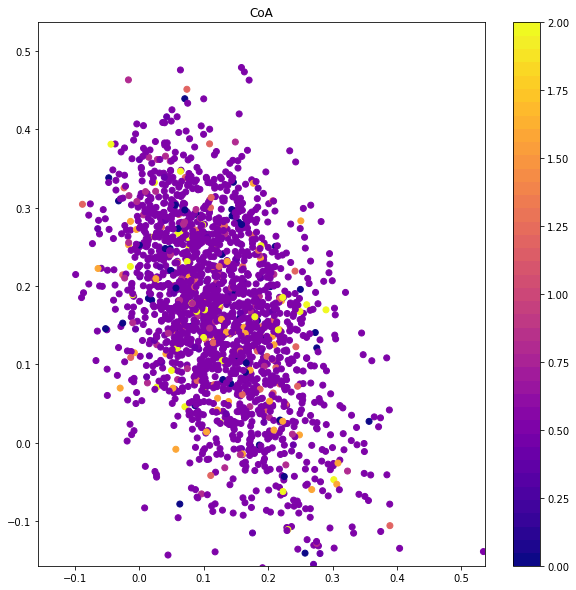

In [53]:
#cm1 = cm.get_cmap('tab20b', 20)
#cm2 = cm.get_cmap('tab20c', 20)
cmap = cm.get_cmap('plasma', 41)
#cmap = lambda x: cm1(x) if x < 21 else cm2(x)
#for j in range(41):
x_test_encoded_agg = np.mean(x_test_encoded, axis=1)
x_test_dim_1, x_test_dim_2 = x_test_encoded_agg[:, 0], x_test_encoded_agg[:, 1]
xmin, xmax = np.amin(x_test_dim_1), np.amax(x_test_dim_2)
ymin, ymax = np.amin(x_test_dim_1), np.amax(x_test_dim_2)
x_diff = (xmax - xmin) / 10.0
y_diff = (ymax - ymin) / 10.0
for col in df.columns[4:]:
    plt.figure(figsize=(10, 10))
    plt.scatter(x_test_dim_1, x_test_dim_2, c=get_rct(df, col, y_test), cmap=cmap)
    plt.xlim((xmin - x_diff, xmax + x_diff))
    plt.ylim((ymin - y_diff, ymax + y_diff))
    plt.title(col)
    plt.colorbar()
    plt.show()

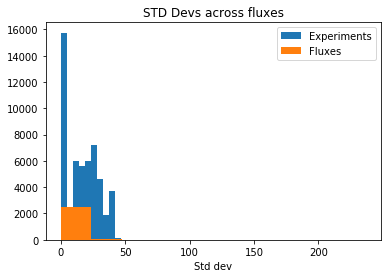

In [390]:
std_trials = np.std(flat_data, axis=1)
std_fluxes = np.std(flat_data, axis=0)
plt.hist(std_trials, label='Experiments')
plt.title('STD Devs across experiments')
plt.hist(std_fluxes, label='Fluxes')
plt.title('STD Devs across fluxes')
plt.xlabel('Std dev')
plt.legend()
plt.show()

In [393]:
sor_flux = np.argsort(std_fluxes)

In [394]:
sor_flux

array([1292, 1053, 1115, ...,  184, 1540,  749])

In [8]:
check_corr(biased_resamp_data, df, btol_col)

[7.71420923e-01 3.57201878e-09]
[(0.7713383904550454, 3.5940168129726762e-09), (0.771301796178708, 3.6039551914596817e-09), (0.7716717290306057, 3.504658533523445e-09), (0.7716818136611554, 3.5019877504629816e-09), (0.77126553345047, 3.613828833639943e-09)]


0.771420922514194

In [9]:
enc = load_model('../models/encoder_epochs=300_batch=256_dimension=2_corr=True.h5')
gen = load_model('../models/generator_epochs=300_batch=256_dimension=2_corr=True.h5')

/home/nlarusstone/.virtualenvs/nls/lib/python2.7/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [96]:
enc_bad = load_model('../models/encoder_epochs=100_batch=256_dimension=2_corr=False.h5')
gen_bad = load_model('../models/generator_epochs=100_batch=256_dimension=2_corr=False.h5')

In [60]:
enc_good = load_model('../models/encoder_epochs=100_batch=256_dimension=10_corr=True.h5')
gen_good = load_model('../models/generator_epochs=100_batch=256_dimension=10_corr=True.h5')

In [36]:
def pred(biased_resamp_data, enc, gen):
    encoded_biased = enc.predict(biased_resamp_data)
    decoded_biased = gen.predict(encoded_biased)
    return check_corr(decoded_biased, df, btol_col)
pred(biased_resamp_data, enc, gen)
pred(biased_resamp_data, enc2, gen2)

[-0.48398877  0.00143965]
[(-0.43424768101710753, 0.004556910904133768), (-0.47539295779803914, 0.0016831106274436394), (-0.4759956582919057, 0.0016571962241744482), (-0.47706551474677766, 0.0016120628315097803), (-0.49609732914712, 0.0009715799117068291)]
[0.20390043 0.20112031]
[(0.20317854062706076, 0.202634176577661), (0.20424329306956487, 0.2002275563467154), (0.20461314402146616, 0.19939630773264982), (0.2057848806826731, 0.1967788069373942), (0.19938385845728376, 0.2113756130391107)]


0.20390043150488082

In [97]:
def add_noise(biased_resamp_data, enc, gen):
    noise_arr = np.logspace(start=-5, stop=1, num=10)
    corrs = []
    for noise in noise_arr:
        noisy_data = biased_resamp_data.copy()
        for i in range(n_experiments):
            s = noisy_data[:, i, :].shape
            noisy_data[:, i, :] += np.random.normal(scale=noise, size=s)
            #noisy_data[:, i, :] = minmax_scale(noisy_data[:, i, :])
        #scaled_noisy_data = scale_by_flux(noisy_data)
        corr = pred(noisy_data, enc, gen)
        corrs.append(corr)
    return zip(noise_arr, corrs) + [(0, pred(biased_resamp_data, enc, gen))]
#noise_res = add_noise(biased_resamp_data, enc, gen)
#noise_res2 = add_noise(biased_resamp_data, enc_good, gen_good)
noise_res3 = add_noise(biased_resamp_data, enc_bad, gen_bad)

[0.20390043 0.20112033]
[(0.20317865822441167, 0.20263390966363137), (0.20424413675220737, 0.20022565738826206), (0.20461183113826745, 0.1993992541767928), (0.20578526491243937, 0.19677795260517644), (0.19938348343368134, 0.21137648968656572)]
[0.20390037 0.20112046]
[(0.20317618210169436, 0.20263952984128852), (0.20424308770211486, 0.20022801858909067), (0.20461150789766758, 0.1993999796156801), (0.20578949156907886, 0.1967685548357473), (0.19938296651328036, 0.21137769803319653)]
[0.20390031 0.20112061]
[(0.20317360809961704, 0.2026453722962261), (0.20424736835876675, 0.20021838381443877), (0.20462782488252665, 0.1993633622246842), (0.20580716009231378, 0.19672927313652588), (0.19940784224076233, 0.21131955428619023)]
[0.20389912 0.20112354]
[(0.20316904271008798, 0.20265573508086707), (0.20410429103944258, 0.20054059425217044), (0.20438938213284538, 0.19989892779576118), (0.2057364308671868, 0.196886555680224), (0.19933249007168044, 0.2114957142420603)]
[0.20387905 0.20116968]
[(0.2

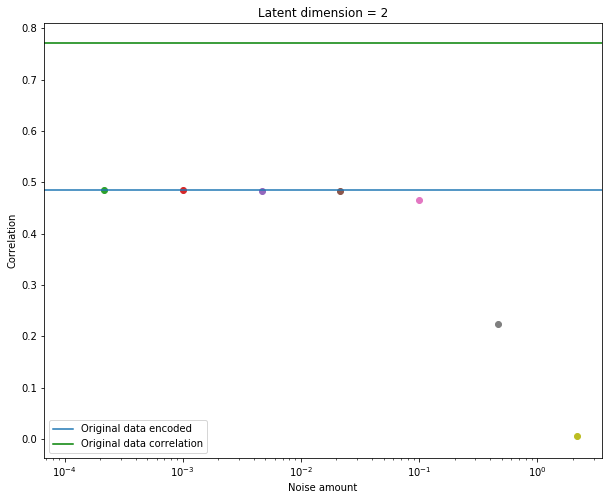

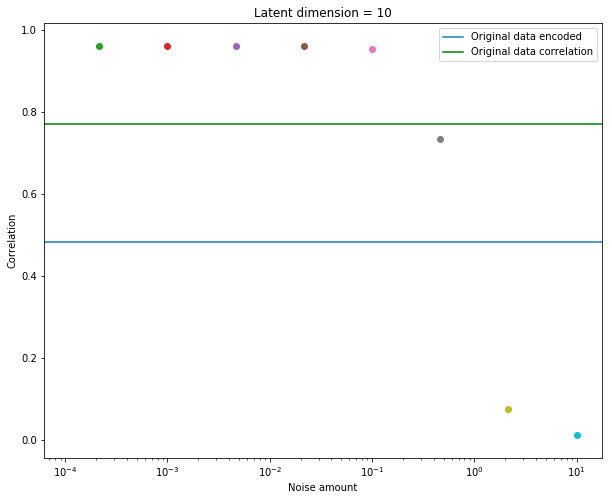

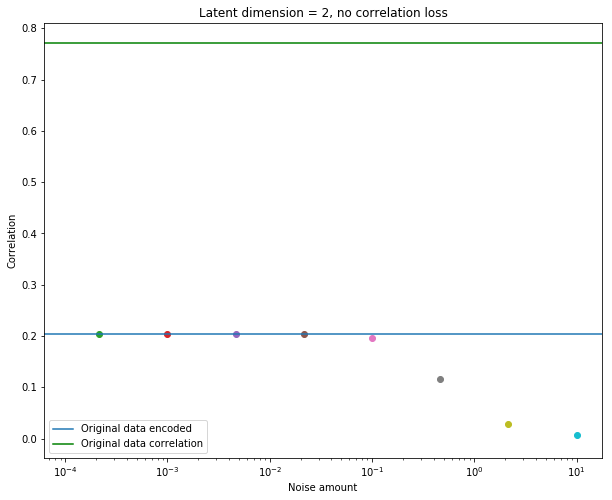

In [103]:
orig_corr = check_corr(biased_resamp_data, df, btol_col)
def plt_noise_corr(noise_data, orig_corr, ndim=2):
    orig_enc, noise_data = noise_data[-1], noise_data[:-1]
    plt.figure(figsize=(10, 8))
    plt.title('Latent dimension = {0}'.format(ndim))
    plt.axhline(y=-1 * orig_enc[1] if orig_enc[1] < 0 else orig_enc[1], label='Original data encoded')
    plt.axhline(y=orig_corr, label='Original data correlation', c='g')
    for noise, corr in noise_data:
        plt.scatter(x=noise, y=-1 * corr if corr < 0 else corr)
        plt.xlabel('Noise amount')
        plt.ylabel('Correlation')
    plt.xscale('log')
    plt.legend()
    plt.show()
plt_noise_corr(noise_res, orig_corr, ndim=2)
plt_noise_corr(noise_res2, orig_corr, ndim=10)
plt_noise_corr(noise_res3, orig_corr, ndim='2, no correlation loss')

In [163]:
test_enc = enc.predict(X_test)
test_dec = gen.predict(test_enc)
dec_df = pd.DataFrame(data=test_dec[:, 0, :], columns=cols)

In [164]:
dec_df.std()

DM_4CRSOL                         1.014719e-01
DM_5DRIB                          7.261308e-03
DM_AACALD                         3.195154e-02
DM_AMOB                           1.012327e-01
DM_MTHTHF                         3.776596e-03
DM_OXAM                           1.266391e-02
Ec_biomass_iJO1366_WT_53p95M      6.266355e-02
Ec_biomass_iJO1366_core_53p95M    2.049949e-02
EX_12ppd__R_e                     3.097374e-02
EX_12ppd__S_e                     1.745071e-02
EX_14glucan_e                     2.720261e-02
EX_15dap_e                        3.201088e-02
EX_23camp_e                       1.090218e-03
EX_23ccmp_e                       1.083901e-02
EX_23cgmp_e                       2.015965e-02
EX_23cump_e                       9.430271e-03
EX_23dappa_e                      3.382107e-04
EX_26dap__M_e                     2.626861e-02
EX_2ddglcn_e                      4.411127e-02
EX_34dhpac_e                      2.003530e-02
EX_3amp_e                         3.108181e-13
EX_3cmp_e    

In [129]:
bad_cols = cols[dec_df.mean() < 0.001]
bad_cols

Index([u'EX_23camp_e', u'EX_23dappa_e', u'EX_3amp_e', u'EX_3hpppn_e',
       u'EX_3ump_e', u'EX_4hoxpacd_e', u'EX_LalaLglu_e', u'EX_acmana_e',
       u'EX_amp_e', u'EX_arbt_e',
       ...
       u'EX_iletrna_e', u'EX_leutrna_e', u'EX_lystrna_e', u'EX_mettrna_e',
       u'EX_trptrna_e', u'EX_phetrna_e', u'EX_protrna_e', u'EX_trnaser_e',
       u'DM_nad_e', u'DM_atp_e'],
      dtype='object', length=405)

In [143]:
import cobra
%load_ext autoreload
import sys
if not '/home/nlarusstone/cf_fba' in sys.path:
    sys.path.append('/home/nlarusstone/cf_fba')
import src.utils as utils
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
model = cobra.io.read_sbml_model('../models/ecoli_cf_base.sbml')

In [167]:
objs = []
for i, row in df.iterrows():
    print i
    model_i = utils.add_reagents_to_model(model, row)
    sol = model_i.optimize()
    objs.append(sol.objective_value)
scipy.stats.pearsonr(objs, df['AVG.1'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


(-0.18599663675598, 0.24429322068473233)

In [170]:
thresh = np.logspace(start=-4, stop=0, num=20)
for t in thresh:
    objs = []
    for i, row in df.iterrows():
        model_i = utils.add_reagents_to_model(model, row)
        dec_df = pd.DataFrame(data=test_dec[:, i, :], columns=cols)
        bad_cols = cols[dec_df.mean() < t]
        model_i.remove_reactions(bad_cols)
        sol = model_i.optimize()
        objs.append(sol.objective_value)
    print t, scipy.stats.pearsonr(objs, df['AVG.1'])

0.0001 (-0.0733534863977497, 0.6485474684411057)
0.0001623776739188721 (-0.09081984333707789, 0.5722670332035837)
0.00026366508987303583 (-0.26142378832809, 0.09873554367667428)
0.00042813323987193956 (-0.2614237883280891, 0.09873554367667543)
0.0006951927961775605 (-0.32720025322515117, 0.03678186514456672)


KeyboardInterrupt: 

In [166]:
scipy.stats.pearsonr(objs, df['AVG.1'])

(-0.4278656938433445, 0.005262101606886686)

In [168]:
objs = []
for i, row in df.iterrows():
    print i
    model_i = utils.add_reagents_to_model(model, row)
    dec_df_g = pd.DataFrame(data=test_dec_good[:, i, :], columns=cols)
    bad_cols = cols[dec_df_g.mean() < 0.01]
    print len(bad_cols)
    model_i.remove_reactions(bad_cols)
    sol = model_i.optimize()
    objs.append(sol.objective_value)
scipy.stats.pearsonr(objs, df['AVG.1'])

0
594
1
407
2
441
3
450
4
430
5
462
6
422
7
461
8
493
9
403
10
423
11
446
12
439
13
424
14
362
15
454
16
422
17
417
18
456
19
434
20
471
21
437
22
440
23
429
24
401
25
412
26
457
27
447
28
447
29
429
30
455
31
459
32
465
33
462
34
362
35
459
36
408
37
424
38
474
39
447
40
407


(-0.12833002786204523, 0.42393349544585157)

In [158]:
test_enc_good = enc_good.predict(X_test)
test_dec_good = gen_good.predict(test_enc)
dec_df_good = pd.DataFrame(data=test_dec[:, 0, :], columns=cols)

In [131]:
bad_cols_2 = cols[dec_df_good.mean() < 0.001]
bad_cols_2

Index([u'EX_23camp_e', u'EX_3ump_e', u'EX_4hoxpacd_e', u'EX_LalaLglu_e',
       u'EX_acmana_e', u'EX_amp_e', u'EX_arbt_e', u'EX_ascb__L_e',
       u'EX_aso3_e', u'EX_cbi_e',
       ...
       u'EX_iletrna_e', u'EX_leutrna_e', u'EX_lystrna_e', u'EX_mettrna_e',
       u'EX_trptrna_e', u'EX_phetrna_e', u'EX_protrna_e', u'EX_trnaser_e',
       u'DM_nad_e', u'DM_atp_e'],
      dtype='object', length=306)

In [135]:
bad_cols_2.isin(bad_cols)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,